In [1]:
# %matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import scipy.stats as ss
from scipy import linalg  # numpy linalg plus extras
import scipy.io as spio
import statsmodels.api as sm

# import pdb
# import matlab.engine

In [2]:
# directories
datadir='/data1/adac/'
processdir=datadir + 'process/'

In [3]:
# regions
class AdACRegion(object):
    def __init__(self, name=None, lon=None, lat=None):
        if name is None:
            raise ValueError("name must be specified")
        self.name = name
        self.lon = lon
        self.lat = lat
    def __str__(self):
        return "%s, %f, %f" % (self.name, self.lon, self.lat)
regions=[AdACRegion('WesternMed',3,38.5),
         AdACRegion('ROAM_MIZ',3.18,61.58)]


In [4]:
# swath file
swfile=datadir + 'ephem_calval_june2015_ell-v2.txt';
print("loading " + swfile)

data=np.loadtxt(swfile,skiprows=4)
swt=data[:,0]
swx=data[:,1]
swy=data[:,2]
# shift lon axis:
# swx[swx>180]=swx[swx>180]-360;
swx[swx>180]-=360;
# % get rid of big jumps
swxm = np.ma.asarray(swx)
dswx=abs(np.diff(swx))
dswx=np.hstack((dswx,0))
ji=dswx>200
swxm[ji] = np.ma.masked
swx=swxm.flatten()

loading /data1/adac/ephem_calval_june2015_ell-v2.txt


In [15]:
# load segmented TSG data
tsgfile=processdir + 'adac_tsg_segments.txt'
print('loading %s' % tsgfile)
# data=np.loadtxt(tsgfile,skiprows=1)
nrows=None # set to some value <50000 for testing, or None to load all (slow)
tsg = pd.read_csv(tsgfile, sep=',', header=0,engine='python',nrows=nrows)
tsg.head()

loading /data1/adac/process/adac_tsg_segments.txt


,x,y,t,dist,T,S,D,speed,callsign
0,-169.138504,-14.608500,733594.267361,0.0,NaN,35.165001,NaN,7.409730,1.0
1,-169.115631,-14.612450,733594.271258,2.5,NaN,35.150407,NaN,7.544748,1.0
2,-169.092772,-14.616475,733594.275098,5.0,NaN,35.136924,NaN,7.445929,1.0
3,-169.069880,-14.620325,733594.278983,7.5,NaN,35.129654,NaN,7.454520,1.0
4,-169.046965,-14.624050,733594.282865,10.0,NaN,35.129466,NaN,7.533735,1.0


In [16]:
# === loop through segments of data & compute mean/std
# variable names:
avars=['x','y','t','callsign'] # non-data variables
datavars=['T','S','D'] # data variables
allvars=avars + datavars
# initialize dataframes:
data_av=pd.DataFrame(columns=allvars)
data_std=pd.DataFrame(columns=datavars)
# loop through segments
x=tsg["x"] # x = nan denotes end of a segment 
ibreak=[i for i, x in enumerate(x) if np.isnan(x)]
# ibreak=ibreak[250:251] # for testing
# ibreak=ibreak[0:1]
# print(ibreak)
# --- specify earlier ---
dwinkm=20 # vary this
DGRID=2.5  # fundamental to the data
dwinpts=int(np.floor(dwinkm/DGRID)+1);  # datapoints per window

# loop through ibreak, which indicate the end of a segment
seg0=0
Ntot=0
cnt=0
for segi in ibreak:
    cnt+=1
    # index of this segment
    thisi=range(seg0,segi)
    seg=tsg.iloc[thisi]
    # increment seg0 * check this *
    seg0=segi+1
    # break into "Nwindows" windows of length dwinpts (dwinkm)
    Nwindows=int(np.floor(seg.shape[0]/dwinpts))
    Ntot+=Nwindows
    # cut to a # of points divisble by dwinpts
    win=range(0,int(Nwindows*dwinpts))
    seg_win=seg.iloc[win]
    # for each variable in seg_win, 
    # reshape so that each COLUMN of seg_win is a
    # "dwinpts"-length window of data
    # (so, there should be Nwindows columns)
#             import pdb; pdb.set_trace()    
    # ----
    std_datavars=[] # stores std of all data variables; reinitialize for each segment
    for v in datavars:
        # reshape this variable into a matrix for fast processing 
        var_win=np.array(seg_win[v]).reshape(Nwindows,dwinpts)
        # metrics: mean/std computed over dwinpts,
        # will have length Nwindows 
        thisvar_std=np.nanstd(var_win,axis=1, ddof=1) # calculate along the cols
        # to add them to the pandas dataframe, we must stick 
        # std from all the variables together 
        std_datavars=np.concatenate((std_datavars,thisvar_std))
            
    # once we've looped through all variables, add to the dataframe
    # - first, have to reshape to be consistent with the existing dataframe:
    std_datavars=std_datavars.reshape(3,Nwindows).T 
    # create a new dataframe
    newdata=pd.DataFrame(std_datavars,columns=datavars)
    # append to the existing dataframe "data_std"
    data_std=data_std.append(newdata,ignore_index=True)
    
    # ---- loop through all variables to get mean:
    av_datavars=[] # reinitialize for each segment
    for v in allvars:
        # reshape this variable into a matrix for fast processing
        var_win=np.array(seg_win[v]).reshape(Nwindows,dwinpts)
        # metrics: mean/std is computed over dwinpts,
        # will have length Nwindows 
        thisvar_av=np.nanmean(var_win,axis=1)
        # to add them to the pandas dataframe, we must stick 
        # mean from all the variables together 
        av_datavars=np.concatenate((av_datavars,thisvar_av)) 
#         if (v=="S") & (cnt==1):
#             print(var_win)
#             print(thisvar_av)
#             print(av_datavars.shape)
    # once we've looped through all variables, add to the dataframe
    # - first, have to reshape to be consistent with the existing dataframe:
    av_datavars=av_datavars.reshape(7,Nwindows).T 
    # create a new dataframe
    newdata=pd.DataFrame(av_datavars,columns=allvars)
    # append to the existing dataframe "data_av"
    data_av=data_av.append(newdata,ignore_index=True)
    # ** add "N" - # of data in mean/std       

In [13]:
print(cnt)

40


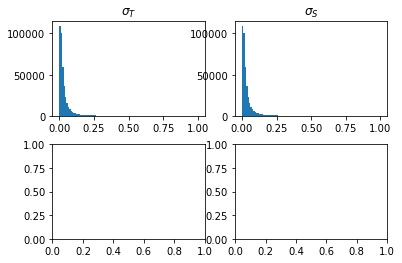

In [17]:
bns=np.linspace(0,1,100)

fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.3)

i=0
for vpl in {"T","S"}:
    ax = axs[0, i]
    ax.hist(data_std["S"], bins=bns);
    ttl=r'$\sigma_%s$' % vpl
    ax.set_title(ttl)    
    i+=1


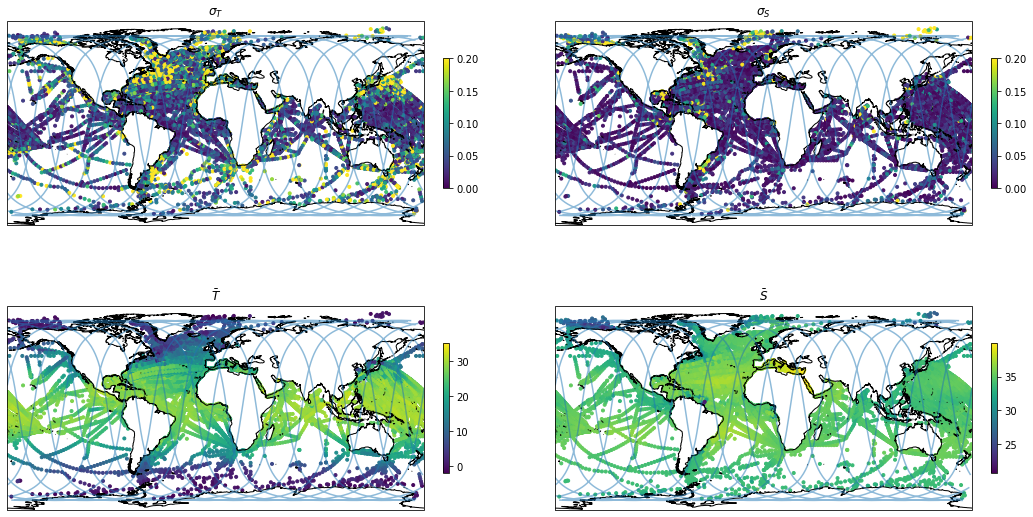

In [20]:
# === plot maps of mean and std dev
plt.figure(figsize=(18,10))
i=0
for vpl in {"T","S"}:
    i+=1
    ax1=plt.subplot(2,2,i, projection=ccrs.PlateCarree())
    plt.subplots_adjust(hspace=0.1)
    ax1.coastlines('50m')
    ax1.plot(swx,swy,alpha=0.5)

    # scatter data
    ipl=10 # subset of data
    cb=ax1.scatter(data_av["x"][::ipl],data_av["y"][::ipl],
                   c=data_std[vpl][::ipl],marker='.',vmin=0,vmax=0.2)
    plt.colorbar(cb,fraction=0.046, pad=0.04, shrink=.5)
    plt.title(r'$\sigma_%s$' % vpl)

for vpl in {"T","S"}:    
    i+=1
    ax1=plt.subplot(2,2,i, projection=ccrs.PlateCarree())
    plt.subplots_adjust(hspace=0.1)
    ax1.coastlines('50m')
    ax1.plot(swx,swy,alpha=0.5)

    cb=plt.scatter(data_av["x"][::ipl],data_av["y"][::ipl],
                   c=data_av[vpl][::ipl],marker='.')
    plt.colorbar(cb,fraction=0.046, pad=0.04, shrink=.5)
    plt.title(r'$\bar{%s}$' % vpl)

plt.show()



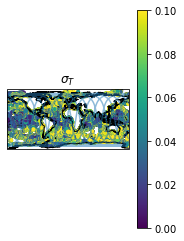

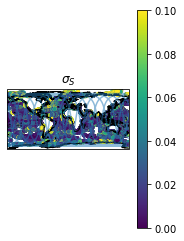

In [21]:
# plot map
def make_plot(x,y,v,vmin=None,vmax=None,title=None,nrows=1,ncols=1,spnum=1):
    ax=plt.subplot(nrows,ncols,spnum, projection=ccrs.PlateCarree())
    
#     plt.subplot(2,2,i, projection=ccrs.PlateCarree())
    ax.coastlines('50m')
    ax.plot(swx,swy,alpha=0.5)
    cb=plt.scatter(x,y,c=v,marker='.',
                  vmin=vmin,vmax=vmax)
    plt.colorbar(cb)
    plt.title(title)


    plt.show()

# -- plot
ipl=1 # subset of data
i=0
nrows=1
ncols=2
for vpl in {"T","S"}:
    i+=1
    ttl=r'$\sigma_%s$' % vpl
    make_plot(data_av["x"][::ipl],data_av["y"][::ipl],data_std[vpl][::ipl],
              vmin=0,vmax=0.1,title=ttl,nrows=nrows,ncols=ncols,spnum=i)


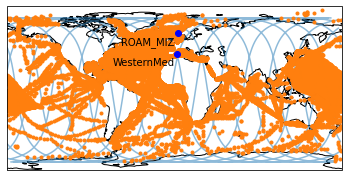

In [24]:
# plot map with regions
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.stock_img()
ax.coastlines()
plt.plot(swx,swy,alpha=0.5)

# tsg data
plt.plot(tsg["x"][::100],tsg["y"][::100],'.')

Nreg=len(regions)
# Nreg=1 # start with first region only
for r in range(Nreg):
    thisreg=regions[r]
    thisx=thisreg.lon
    thisy=thisreg.lat

    plt.plot(thisx, thisy,color='blue', marker='o')
    plt.text(thisx - 3, thisy-12, thisreg.name,
         horizontalalignment='right',
         transform=ccrs.Geodetic())

plt.show()

In [ ]:
# load Matlab format data- doesn't work because Matlab doesn't support python 3.8 ...
# will have to install 3.7 to load/run matlab
# import matlab.engine
if False:
    ddir='/data1/adac/process/'
    fn='adac_tsg_segments_vector.mat'
    print(ddir + fn)
    tsgseg = spio.loadmat(ddir + fn)
    print(tsgseg)

In [ ]:
# dict to store data?
sw = dict(x=swx, y=swy)
print(sw)



In [ ]:
# test

df = pd.DataFrame([[1, 2,2], [3, 4,2]], columns=list('ABC'))
df2 = pd.DataFrame([[5, 6,3], [7, 8,3]], columns=list('ABC'))
df=df.append(df2,ignore_index=True)
print(df)
print()

# test=pd.DataFrame(data=None,columns=datavars)
# test=pd.DataFrame([[1,1,1]], columns=datavars)
test=pd.DataFrame(columns=datavars)
# newdata=pd.Series(data=[1,2,3],index=test.columns)
# # test=test.append(newdata)
# test=test.append(newdata,ignore_index=True)
# test=test.append(newdata,ignore_index=True)
print(test)
newdata2=pd.DataFrame([[8,8,8],[9,9,9]],columns=datavars)
test=test.append(newdata2,ignore_index=True)
print()
print(test)


print()